In [109]:
import pandas as pd
import numpy as np
from scipy.optimize import fsolve
from scipy.stats import norm
from tqdm.notebook import tqdm
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
display(HTML("<style>.container {width:95% !important;}</style>"))

In [3]:
sigma11 = 0.06
sigma12 = 0.00
sigma21 = 0.04
sigma22 = 0.03

kappa1  = 0.05
kappa2  = 0.06

sigmas = np.array([[sigma11, sigma12], 
                   [sigma21, sigma22]])
kappas = np.array([kappa1, kappa2])

ycrv_t     = [0.01, 1, 2, 3, 5, 10, 20, 30]
ycrv_rates = [0.03,0.031, 0.033, 0.037, 0.04, 0.042, 0.046, 0.05]

In [42]:
def g(t, sigmas, kappas):
    return sigmas*np.exp(t*kappas)

def h(t, kappas):
    return np.exp(-t*kappas)

def H(t, kappas):
    return np.diag(h(t,kappas))
    
def sigmax(sigmas):
    sig_x = np.copy(sigmas)
    sig_x[0,1] = 0 #sigma12 = 0
    return sig_x

def sigmap(t, T, sigmas, kappas):
    h_integral = ((np.exp(-kappas*t)-np.exp(-kappas*T))/kappas)
    return g(t, sigmas, kappas) @ h_integral

def kappa_mat(kappas):
    return np.diag(kappas)

def M(t, T, kappas):
    return np.exp(-(T-t)*kappas)

def G(t, T, kappas):
    return (1.0-np.exp(-(T-t)*kappas))/kappas

def y(t, sigmas, kappas):
    kappa1, kappa2 = kappas
    sigma11, sigma12, sigma21, sigma22 = sigmas.flatten()
    gg11 = (np.exp(2*kappa1*t)-1)*(sigma11**2 + sigma21**2)/(2*kappa1)
    gg12 = (np.exp(sum(kappas)*t)-1)*(sigma11*sigma12+sigma21*sigma22)/sum(kappas)
    gg21 = gg12
    gg22 = (np.exp(2*kappa2*t)-1)*(sigma12**2 + sigma22**2)/(2*kappa2)
    gg_integral = np.array([[gg11, gg12], [gg21, gg22]])
    return H(t, kappas) @ gg_integral @ H(t, kappas)

def P(t,T, Pt, PT, sigmas, kappas, x):
    ''' 
        Function computes bond price given x = x(t): P(t, T| x(t) = x)
    '''
    A = -0.5* G(t, T, kappas) @ y(t, sigmas, kappas) @ G(t, T, kappas)
    return PT/Pt*np.exp(-G(t, T, kappas) @ np.array(x) + A)

def var(T, sigmas, kappas):
    sigma_square_sums = (np.transpose(sigmas)**2).sum(axis = 1)
    return (1-np.exp(-2*kappas*T))/(2*kappas)*sigma_square_sums

def cov(T, sigmas, kappas):
    kappa_integral = (1-np.exp(-sum(kappas)*T))/sum(kappas)
    return sum(sigmas.prod(axis = 1))*kappa_integral
    
def mu1_cond(T, sigmas, kappas, x2):
    return cov(T, sigmas, kappas)/var(T,sigmas,kappas)[1]*x2

def s1_sq_cond(T, sigmas, kappas):
    var1, var2 = var(T, sigmas, kappas)
    return var1 - (cov(T,sigmas, kappas)**2)/var2
    
def v(t, sigmas, kappas):
    return np.sum(y(t, sigmas, kappas), axis = 1)

def vT0(t, T0, sigmas, kappas):
    return v(t, sigmas, kappas) - np.transpose(sigmas) @ sigmap(t, T0, sigmas, kappas)

In [139]:
def disc(t, ycrv_t, ycrv_rates, freq = 2):
    return 1.0/(1.0+np.interp(np.array(t), ycrv_t, ycrv_rates)/freq)**(freq * np.array(t))


def swap_value(w, K, T0, TN, freq, sigmas, kappas, ycrv_t, ycrv_rates, x):
    # w=-1 payer swap; w=1 receiver swap
    yearfrac = 1/freq
    coupon_times = np.arange(T0+yearfrac, TN+0.0001, yearfrac)
    PT0 = disc(T0, ycrv_t, ycrv_rates)
    PTi = disc(coupon_times, ycrv_t, ycrv_rates)
    bond_prices = np.zeros_like(coupon_times)
    for i in range(len(coupon_times)):
        bond_prices[i] = P(T0, coupon_times[i], PT0, PTi[i], sigmas, kappas, x)
    return -w*1 + w*bond_prices[-1] + w*K*yearfrac*bond_prices.sum()

def get_strikes(w, K, T0, TN, freq, sigmas, kappas, ycrv_t, ycrv_rates, x2):
    '''
        For a given x2, find critical x1 = x1*(x2) and compute strikes Ki=P(T0,Ti, x1, x2) 
        for Jamshidian decomposition
    '''
    x1_crit = fsolve(lambda x1: swap_value(w, K, T0, TN, freq, sigmas, kappas, ycrv_t, ycrv_rates, [x1, x2]),
                     x0 = [0])[0]
    x = [x1_crit, x2]
    yearfrac = 1/freq
    coupon_times = np.arange(T0+yearfrac, TN+0.0001, yearfrac)
    Ki = []
    PT0 = disc(T0, ycrv_t, ycrv_rates, freq = 2)
    for Ti in coupon_times:
        Ki.append(P(T0, Ti, PT0, disc(Ti, ycrv_t, ycrv_rates, freq = 2), sigmas, kappas, x))
    return coupon_times, Ki

def bond_put_option(T, s, K, sigmas, kappas, ycrv_t, ycrv_rates, x2):
    df        = lambda t: disc(t, ycrv_t, ycrv_rates, freq = 2)
    variances = var(T, sigmas, kappas)
    covs      = cov(T, sigmas, kappas)
    mu1       = mu1_cond(T, sigmas, kappas, x2)
    s1_sq     = s1_sq_cond(T, sigmas, kappas)
    G1, G2    = G(T, s, kappas)
    omega     = -mu1*G1 + 0.5*(G1**2)*s1_sq
    A         = -0.5* G(T, s, kappas) @ y(T, sigmas, kappas) @ G(T, s, kappas)
    
    K_star    = df(T)/df(s)*np.exp(-A+x2*G2)*K
    d = lambda sign: (omega-np.log(K_star)+sign*0.5*(G1**2)*s1_sq)/(G1*np.sqrt(s1_sq))
    
    value = df(s)*np.exp(A-x2*G2)*(K_star*norm.cdf(-d(-1))-np.exp(omega)*norm.cdf(-d(1)))
    return value

def bond_call_option(T, s, K, sigmas, kappas, ycrv_t, ycrv_rates, x2):
    df        = lambda t: disc(t, ycrv_t, ycrv_rates, freq = 2)
    variances = var(T, sigmas, kappas)
    covs      = cov(T, sigmas, kappas)
    mu1       = mu1_cond(T, sigmas, kappas, x2)
    s1_sq     = s1_sq_cond(T, sigmas, kappas)
    G1, G2    = G(T, s, kappas)
    omega     = -mu1*G1 + 0.5*(G1**2)*s1_sq
    A         = -0.5* G(T, s, kappas) @ y(T, sigmas, kappas) @ G(T, s, kappas)
    
    K_star    = df(T)/df(s)*np.exp(-A+x2*G2)*K
    d = lambda sign: (omega-np.log(K_star)+sign*0.5*(G1**2)*s1_sq)/(G1*np.sqrt(s1_sq))
    
    value = df(s)*np.exp(A-x2*G2)*(np.exp(omega)*norm.cdf(d(1))-K_star*norm.cdf(d(-1)))
    return value

def payer_swaption(K, T0, TN, freq, sigmas, kappas, ycrv_t, ycrv_rates):
    
    def payer_swaption_x2_cond(K, T0, TN, freq, sigmas, kappas, ycrv_t, ycrv_rates, x2):
        coupon_times, strikes = get_strikes(-1, K, T0, TN, freq, sigmas, kappas, ycrv_t, ycrv_rates, x2)
        bond_option = []
        for Ti, Ki in zip(coupon_times, strikes):
            bond_option.append(bond_put_option(T0, Ti, Ki, sigmas, kappas, ycrv_t, ycrv_rates, x2))    
        var_x2 = var(T0, sigmas, kappas)[1]
        return (bond_option[-1]+K*1/freq*sum(bond_option))/np.sqrt(var_x2)*norm.pdf(x2/np.sqrt(var_x2))
        
    x2_grid = np.linspace(-0.35, 0.35, 800)
    swaption_val_x2 = []
    for x2 in x2_grid:
        swaption_val_x2.append(payer_swaption_x2_cond(K, T0, TN, freq, sigmas, kappas, ycrv_t, ycrv_rates, x2))
    
    return np.trapz(swaption_val_x2, x2_grid)

def receiver_swaption(K, T0, TN, freq, sigmas, kappas, ycrv_t, ycrv_rates):
    
    def receiver_swaption_x2_cond(K, T0, TN, freq, sigmas, kappas, ycrv_t, ycrv_rates, x2):
        coupon_times, strikes = get_strikes(-1, K, T0, TN, freq, sigmas, kappas, ycrv_t, ycrv_rates, x2)
        bond_option = []
        for Ti, Ki in zip(coupon_times, strikes):
            bond_option.append(bond_call_option(T0, Ti, Ki, sigmas, kappas, ycrv_t, ycrv_rates, x2))    
        var_x2 = var(T0, sigmas, kappas)[1]
        return (bond_option[-1]+K*1/freq*sum(bond_option))/np.sqrt(var_x2)*norm.pdf(x2/np.sqrt(var_x2))
        
    x2_grid = np.linspace(-0.35, 0.35, 800)
    swaption_val_x2 = []
    for x2 in x2_grid:
        swaption_val_x2.append(receiver_swaption_x2_cond(K, T0, TN, freq, sigmas, kappas, ycrv_t, ycrv_rates, x2))
    
    return np.trapz(swaption_val_x2, x2_grid)

def q(t, T0, TN, sigmas, kappas, ycrv_t, ycrv_rates, x = [0.0, 0.0], freq = 2):
    Pt = disc(t, ycrv_t, ycrv_rates, freq = 2)
    yearfrac = 1/freq
    times = np.arange(T0, TN+0.0001, yearfrac)
    bond_prices = []
    G_vals = []
    for T in times:
        bond_prices.append(P(t,T, Pt, disc(T, ycrv_t, ycrv_rates, freq = 2), sigmas, kappas, x))
        G_vals.append(G(t, T, kappas))
    bond_prices = np.array(bond_prices)
    G_vals = np.array(G_vals)
    G1_vals, G2_vals = G_vals[:,0], G_vals[:,1]
    
    A = yearfrac * bond_prices[1:].sum()
    S = (bond_prices[0] - bond_prices[-1])/A
    
    q1 =(bond_prices[0]*G1_vals[0]-bond_prices[-1]*G1_vals[-1])/A-S*yearfrac*(G1_vals[1:]*bond_prices[1:]).sum()/A
    q2 =(bond_prices[0]*G2_vals[0]-bond_prices[-1]*G2_vals[-1])/A-S*yearfrac*(G2_vals[1:]*bond_prices[1:]).sum()/A
    
    return np.array([q1, q2])
    
def payer_swaption_approx(K, T0, TN, sigmas, kappas, ycrv_t, ycrv_rates, x = [0.0, 0.0], freq = 2):
    integrand = lambda t: np.linalg.norm(q(t,T0,TN,sigmas,kappas,ycrv_t,ycrv_rates,x,freq) @ np.transpose(sigmas))**2
    t_grid = np.linspace(0,T0, int(12*T0))
    integrand_val = []
    for t in t_grid:
        integrand_val.append(integrand(t))
    v = np.trapz(integrand_val, t_grid)
    
    yearfrac = 1/freq
    times = np.arange(T0, TN+0.0001, yearfrac)
    bond_prices = disc(times, ycrv_t, ycrv_rates, freq = 2)
    A = yearfrac * bond_prices[1:].sum()
    S = (bond_prices[0]-bond_prices[-1])/A
    d = (S - K)/np.sqrt(v)
    return A*((S-K)*norm.cdf(d)+np.sqrt(v)*norm.pdf(d))

def receiver_swaption_approx(K, T0, TN, sigmas, kappas, ycrv_t, ycrv_rates, x = [0.0, 0.0], freq = 2):
    
    integrand = lambda t: np.linalg.norm(q(t,T0,TN,sigmas,kappas,ycrv_t,ycrv_rates,x,freq) @ np.transpose(sigmas))**2
    t_grid = np.linspace(0,T0, int(12*T0))
    integrand_val = []
    for t in t_grid:
        integrand_val.append(integrand(t))
    v = np.trapz(integrand_val, t_grid)
    
    yearfrac = 1/freq
    times = np.arange(T0, TN+0.0001, yearfrac)
    bond_prices = disc(times, ycrv_t, ycrv_rates, freq = 2)
    A = yearfrac * bond_prices[1:].sum()
    S = (bond_prices[0]-bond_prices[-1])/A
    d = (S - K)/np.sqrt(v)
    return A*((K-S)*norm.cdf(-d)+np.sqrt(v)*norm.pdf(-d))

In [7]:
swap_value(-1, 0.058, 2, 7, 2, sigmas, kappas, ycrv_t, ycrv_rates, x = [0.00, 0.00])
#find_critical_x1(-1, 0.058, 2, 7, 2, sigmas, kappas, ycrv_t, ycrv_rates, x2 = 0.0)
get_strikes(-1, 0.058, 2, 7, 2, sigmas, kappas, ycrv_t, ycrv_rates, x2 = 0)
bond_put_option(T=1, s=5, K=0.79, sigmas=sigmas, kappas=kappas, ycrv_t=ycrv_t, ycrv_rates=ycrv_rates, x2=0.0)
print(payer_swaption(0.058, 2, 7, 2, sigmas, kappas, ycrv_t, ycrv_rates))
print(receiver_swaption(0.058, 2, 7, 2, sigmas, kappas, ycrv_t, ycrv_rates))
#q(0, 2, 7, sigmas, kappas, ycrv_t, ycrv_rates, x = [0.0, 0.0], freq = 2)
print(payer_swaption_approx(0.058, 2, 7, sigmas, kappas, ycrv_t, ycrv_rates, x = [0.0, 0.0], freq = 2))
print(receiver_swaption_approx(0.058, 2, 7, sigmas, kappas, ycrv_t, ycrv_rates, x = [0.0, 0.0], freq = 2))

0.15669065319192452
0.21512913800078298
0.1582501718375755
0.21668865664643377


In [46]:
dt = 1/252
T0 = 2
TN = 7
K  = 0.058
n_simuls = 10000

def simulate_x(n_simuls, T0, sigmas, kappas, dt):
    t_grid = np.arange(dt, T0+0.0001, dt)
    dW = lambda: np.sqrt(dt)*np.random.normal(size = 2)
    x_final = []
    
    for simul in tqdm(range(n_simuls)):
        x = np.array([0.0, 0.0])
        for t in t_grid:
            x += (vT0(t, T0, sigmas, kappas) - kappas * x)*dt + np.transpose(sigmas) @ dW()
        x_final.append(x)
    return np.array(x_final)

def payoff(x, T0, TN, K, ycrv_t, ycrv_rates, freq = 2):
    yearfrac = 1/freq
    times = np.arange(T0+yearfrac, TN+0.0001, yearfrac)
    PT0 = disc(T0, ycrv_t, ycrv_rates, freq = 2)
    bond_prices = []
    for Ti in times:
        bond_prices.append(P(T0,Ti, PT0, disc(Ti, ycrv_t, ycrv_rates, 2), sigmas, kappas, x))
    return np.max([-(1 - bond_prices[-1] - K*yearfrac*sum(bond_prices)),0])

payoffs = []
x_final = simulate_x(n_simuls, T0, sigmas, kappas, dt)
for i in range(len(x_final)):
    payoffs.append(payoff(x_final[i,:]), 2, 7, 0.058, ycrv_t, ycrv_rates, freq = 2)
    
pd.Series(payoffs).mean()*disc(T0, ycrv_t, ycrv_rates,2)

TypeError: payoff() missing 5 required positional arguments: 'T0', 'TN', 'K', 'ycrv_t', and 'ycrv_rates'

In [49]:
for i in range(len(x_final)):
    payoffs.append(payoff(x_final[i,:], 2, 7, 0.058, ycrv_t, ycrv_rates, freq = 2))

In [48]:
payoff(x_final[i,:])

TypeError: payoff() missing 5 required positional arguments: 'T0', 'TN', 'K', 'ycrv_t', and 'ycrv_rates'

In [50]:
pd.Series(payoffs).mean()*disc(T0, ycrv_t, ycrv_rates,2)

0.21687733351572594

In [ ]:
(1-np.exp(-2*kappas*10))/(2*kappas)

In [ ]:
y(1, sigmas, kappas)

In [ ]:
vT0(1, 3, sigmas, kappas)

In [ ]:
np.transpose(sigmas) @ sigmap(1, 3, sigmas, kappas)

In [ ]:
sigmap(1, 3, sigmas, kappas)

In [ ]:
sigmap(1, 10, sigmas, kappas)

In [ ]:
np.linalg.norm([1, 2])

In [2]:
np.array([[1, 1],[1, 1]])*np.array([1, 2])

array([[1, 2],
       [1, 2]])

In [44]:
def get_df(t, ycrv_t, ycrv_rates, ycrv_freq):
    ''' 
        discout factor function
    '''
    return 1.0/(1.0+np.interp(t, ycrv_t, ycrv_rates)/ycrv_freq)**(t*ycrv_freq)

def fwd_swap_rate(T_start, T_end, swap_yearfrac, ycrv_t, ycrv_rates, ycrv_freq):
    ''' 
        function calculates forward swap rate R
        for a swap starting at T_start and ending at T_end
    '''
    
    coupon_dates = np.arange(T_start, T_end+0.0001, swap_yearfrac)
    df = get_df(coupon_dates, ycrv_t, ycrv_rates, ycrv_freq)
    
    f = (df[0] - df[-1])/(swap_yearfrac * np.sum(df[1:]))
    return f

def swaption(T_start, T_end, K, IRS_type, sigma, swap_yearfrac, ycrv_t, ycrv_rates, ycrv_freq, model, shift = 0):
    '''
        calculate swaption price. The underlying is a swap starting at T_start and ending at T_end
        where T_start is also the expiry of the swaption
        model is either normal, or (shifted)lognormal; normal model takes no shift
    '''
    f            = fwd_swap_rate(T_start, T_end, swap_yearfrac, ycrv_t, ycrv_rates, ycrv_freq)
    coupon_dates = np.arange(T_start, T_end+0.0001, swap_yearfrac)
    df           = get_df(coupon_dates, ycrv_t, ycrv_rates, ycrv_freq)
    annuity      = swap_yearfrac*np.sum(df[1:])
    
    w = {'payer':-1, 'receiver':1}[IRS_type.lower()]
    
    if model.lower() == 'lognormal':
        d1      = (np.log((f+shift)/(K+shift)) + (0.5* sigma**2 * T_start))/(sigma*np.sqrt(T_start))
        d2      = d1 - sigma*np.sqrt(T_start)
        price   = (w*(K+shift)*norm.cdf(-w*d2) - w*(R+shift)*norm.cdf(-w*d1))*annuity
    elif model.lower() == 'normal':
        d       = -w * (f-K)*(sigma * np.sqrt(T_start))
        price   = sigma * np.sqrt(T_start) * (d * norm.cdf(d) + norm.pdf(d)) * annuity
    else:
        print(f'Swaption pricing: unknown model {model}')
      
    return price

In [46]:
ycrv = pd.read_csv('IR_curve_EUR_2019_07_31.csv')
vols = pd.read_csv('normal_volsurface_2019_07_31.csv')
vols = vols.rename(columns = {'expiry/tenor':'expiry'}).set_index('expiry').rename_axis('tenor', axis = 1)
ycrv.head()

,maturity,value
0,0.019231,-0.00437
1,0.083333,-0.00450
2,0.166667,-0.00426
3,0.250000,-0.00396
4,0.500000,-0.00401


In [137]:
stacked_vols = vols.stack().reset_index().rename(columns = {0:'sigma_normal'})
stacked_vols['tenor'] = stacked_vols['tenor'].astype(float) 
stacked_vols['TN'] = stacked_vols.eval('expiry+tenor')
selected_vols = stacked_vols.query('expiry >=1 and tenor >=1').rename(columns = {'expiry':'T0'}).drop('tenor', axis = 1)
selected_vols = selected_vols[['T0', 'TN', 'sigma_normal']]
#selected_vols

In [48]:
def get_err(params, df_vol_quotes, swap_yearfrac, ycrv_t, ycrv_rates, ycrv_freq):
    kappa1, kappa2, sigma1, sigma2, rho = params
    
    sigmas = np.array([[sigma1, sigma2*rho],[0, sigma2*np.sqrt(1-rho**2)]])
    kappas = np.array([kappa1, kappa2])
    
    market_vals, model_vals = [], []
    for _, row in df_vol_quotes.iterrows():
        T0, TN, sigma_normal = row 
        f = fwd_swap_rate(T0, TN, swap_yearfrac, ycrv_t, ycrv_rates, ycrv_freq)
        mkt_val = swaption(T0, TN, f, 'payer', sigma_normal, swap_yearfrac, ycrv_t, ycrv_rates, ycrv_freq, 'normal')
        model_val = payer_swaption_approx(f, T0, TN, sigmas, kappas, ycrv_t, ycrv_rates, x = [0.0, 0.0], freq = 2)
        market_vals.append(mkt_val)
        model_vals.append(model_val)
    sq_err = np.sqrt(((np.array(model_vals)-np.array(market_vals))**2).mean())
    print(f'params {params}, error: {sq_err}')
    return sq_err

In [49]:
def get_err_lsq(params, df_vol_quotes, swap_yearfrac, ycrv_t, ycrv_rates, ycrv_freq):
    kappa1, kappa2, sigma1, sigma2, rho = params
    
    sigmas = np.array([[sigma1, sigma2*rho],[0, sigma2*np.sqrt(1-rho**2)]])
    kappas = np.array([kappa1, kappa2])
    
    market_vals, model_vals = [], []
    for _, row in df_vol_quotes.iterrows():
        T0, TN, sigma_normal = row 
        f = fwd_swap_rate(T0, TN, swap_yearfrac, ycrv_t, ycrv_rates, ycrv_freq)
        mkt_val = swaption(T0, TN, f, 'payer', sigma_normal, swap_yearfrac, ycrv_t, ycrv_rates, ycrv_freq, 'normal')
        model_val = payer_swaption_approx(f, T0, TN, sigmas, kappas, ycrv_t, ycrv_rates, x = [0.0, 0.0], freq = 2)
        market_vals.append(mkt_val)
        model_vals.append(model_val)
    sq_err = np.sqrt(((np.array(model_vals)-np.array(market_vals))**2).mean())
    print(f'params {params}, error: {sq_err}')
    return (np.array(model_vals)-np.array(market_vals))

In [9]:
from scipy.optimize import minimize
fun = lambda params: get_err(params, selected_vols, 0.5, ycrv['maturity'], ycrv['value'], ycrv_freq = 99999)
res = minimize(fun, x0 = [0.015, 0.013, 0.00627, 0.00148, 0.9], tol=1e-6, options = {'disp':True},
              bounds = ((0.00001, None), (0.00001, None), (0.00001, None), (0.00001, None), (-0.9999, 0.9999)))

params [0.015   0.013   0.00627 0.00148 0.9    ], error: 0.005673959505805713
params [0.01500001 0.013      0.00627    0.00148    0.9       ], error: 0.005673958020897882
params [0.015      0.01300001 0.00627    0.00148    0.9       ], error: 0.005673959172401602
params [0.015      0.013      0.00627001 0.00148    0.9       ], error: 0.005673999463727488
params [0.015      0.013      0.00627    0.00148001 0.9       ], error: 0.005673997407776944
params [0.015      0.013      0.00627    0.00148    0.90000001], error: 0.005673959555060744
params [1.63490783e-01 4.63404112e-02 1.00000000e-05 1.00000000e-05
 8.95074497e-01], error: 0.03078145841215198
params [1.63490793e-01 4.63404112e-02 1.00000000e-05 1.00000000e-05
 8.95074497e-01], error: 0.03078145841234176
params [1.63490783e-01 4.63404212e-02 1.00000000e-05 1.00000000e-05
 8.95074497e-01], error: 0.030781458412564872
params [1.63490783e-01 4.63404112e-02 1.00100000e-05 1.00000000e-05
 8.95074497e-01], error: 0.030781454281953013
par

KeyboardInterrupt: 

In [18]:
from scipy.optimize import least_squares
fun = lambda params: get_err_lsq(params, selected_vols, 0.5, ycrv['maturity'], ycrv['value'], ycrv_freq = 99999)
res = least_squares(fun, x0 = [0.03, 0.36, 0.01, 0.015, -0.9], verbose=2,
                   bounds = ([0.0001, 0.0001, 0.0001, 0.0001, -0.9999], [np.inf, np.inf, np.inf, np.inf, 0.9999]))

params [ 0.03   0.36   0.01   0.015 -0.9  ], error: 0.0020495752681858074
params [ 0.03000001  0.36        0.01        0.015      -0.9       ], error: 0.0020495731101620738
params [ 0.03        0.36000001  0.01        0.015      -0.9       ], error: 0.002049575597634224
params [ 0.03        0.36        0.01000001  0.015      -0.9       ], error: 0.0020496113604249115
params [ 0.03        0.36        0.01        0.01500001 -0.9       ], error: 0.002049569037345815
params [ 0.03        0.36        0.01        0.015      -0.90000001], error: 0.0020495750922734086
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.1552e-04                                    4.71e-02    
params [ 0.02655129  0.38312182  0.01029986  0.02226992 -0.89373751], error: 0.0013465544901463946
params [ 0.02655131  0.38312182  0.01029986  0.02226992 -0.89373751], error: 0.001346552399311061
params [ 0.02655129  0.38312184  0.01029986  0.0222699

params [ 0.06977187  0.58041803  0.01343077  0.04004461 -0.96988637], error: 0.00035253815602386267
params [ 0.06977186  0.58041805  0.01343077  0.04004461 -0.96988637], error: 0.000352538060536943
params [ 0.06977186  0.58041803  0.01343078  0.04004461 -0.96988637], error: 0.00035253687344139004
params [ 0.06977186  0.58041803  0.01343077  0.04004463 -0.96988637], error: 0.00035253817537034195
params [ 0.06977186  0.58041803  0.01343077  0.04004461 -0.96988639], error: 0.0003525380826631284
      11             17         3.4178e-06      9.25e-08       8.16e-03       1.56e-03    
params [ 0.07299111  0.56518005  0.01389276  0.03997822 -0.97198791], error: 0.00034875458771446255
params [ 0.07299113  0.56518005  0.01389276  0.03997822 -0.97198791], error: 0.0003487550105202302
params [ 0.07299111  0.56518006  0.01389276  0.03997822 -0.97198791], error: 0.0003487545248317669
params [ 0.07299111  0.56518005  0.01389278  0.03997822 -0.97198791], error: 0.00034874948824476377
params [ 0.072

KeyboardInterrupt: 

In [50]:
def get_err_lsq_lmfit(params, df_vol_quotes, swap_yearfrac, ycrv_t, ycrv_rates, ycrv_freq):
    parvals = params.valuesdict()
    kappa1 = parvals['kappa1']
    kappa2 = parvals['kappa2']
    sigma1 = parvals['sigma1']
    sigma2 = parvals['sigma2']
    rho    = parvals['rho']
    sigmas = np.array([[sigma1, sigma2*rho],[0, sigma2*np.sqrt(1-rho**2)]])
    kappas = np.array([kappa1, kappa2])
    
    market_vals, model_vals = [], []
    for _, row in df_vol_quotes.iterrows():
        T0, TN, sigma_normal = row 
        f = fwd_swap_rate(T0, TN, swap_yearfrac, ycrv_t, ycrv_rates, ycrv_freq)
        mkt_val = swaption(T0, TN, f, 'payer', sigma_normal, swap_yearfrac, ycrv_t, ycrv_rates, ycrv_freq, 'normal')
        model_val = payer_swaption_approx(f, T0, TN, sigmas, kappas, ycrv_t, ycrv_rates, x = [0.0, 0.0], freq = 2)
        market_vals.append(mkt_val)
        model_vals.append(model_val)
    sq_err = np.sqrt(((np.array(model_vals)-np.array(market_vals))**2).mean())
    print(f'{kappa1},{kappa2},{sigma1},{sigma2},{rho}, error: {sq_err}')
    return (np.array(model_vals)-np.array(market_vals))

In [55]:
from lmfit import Parameters, Minimizer
params = Parameters()
params.add_many(('kappa1', 0.15,  True, 0.0001, 0.6, None, None),
                ('kappa2', 0.4,  True, 0.0001, 0.6, None, None),
                ('sigma1', 0.05,  True, 0.0001, 0.1, None, None),
                ('sigma2', 0.05, True, 0.0001, 0.1, None, None),
                ('rho',   -0.95,   True,-0.9999,0.9999, None, None))
fun = lambda params: get_err_lsq_lmfit(params, selected_vols, 0.5, ycrv['maturity'], ycrv['value'], ycrv_freq = 99999)
fitter = Minimizer(fun, params = params)
fitter.minimize(method = 'least_squares')

0.15,0.4,0.05,0.05,-0.95, error: 0.054274120942628956
0.1500000149011612,0.4,0.05,0.05,-0.95, error: 0.05427411224485049
0.15,0.4000000149011612,0.05,0.05,-0.95, error: 0.054274122845142575
0.15,0.4,0.0500000149011612,0.05,-0.95, error: 0.05427415550695001
0.15,0.4,0.05,0.0500000149011612,-0.95, error: 0.05427411036834001
0.15,0.4,0.05,0.05,-0.9500000149011611, error: 0.05427411996262886
0.19554087699205364,0.35752033125266863,0.04472205625829083,0.05549278820688494,-0.9555621939754418, error: 0.012294885433704016
0.19554089189321483,0.35752033125266863,0.04472205625829083,0.05549278820688494,-0.9555621939754418, error: 0.012294880285814417
0.19554087699205364,0.3575203461538298,0.04472205625829083,0.05549278820688494,-0.9555621939754418, error: 0.012294887489498028
0.19554087699205364,0.35752033125266863,0.04472207115945202,0.05549278820688494,-0.9555621939754418, error: 0.01229490930043755
0.19554087699205364,0.35752033125266863,0.04472205625829083,0.055492803108046135,-0.95556219397

0.10784538341288218,0.21292012729107584,0.02993439752119533,0.03904095212043414,-0.9839415628926532, error: 0.00020230089384358217
0.10784539831404337,0.21292012729107584,0.02993439752119533,0.03904095212043414,-0.9839415628926532, error: 0.00020230117561784318
0.10784538341288218,0.21292014219223704,0.02993439752119533,0.03904095212043414,-0.9839415628926532, error: 0.00020230079264169196
0.10784538341288218,0.21292012729107584,0.029934412422356525,0.03904095212043414,-0.9839415628926532, error: 0.0002022996697182009
0.10784538341288218,0.21292012729107584,0.02993439752119533,0.03904096702159533,-0.9839415628926532, error: 0.0002023014560737433
0.10784538341288218,0.21292012729107584,0.02993439752119533,0.03904095212043414,-0.9839415777938144, error: 0.00020230100698803098
0.10328156994924938,0.20073933418372686,0.030335369006981014,0.03905607064919148,-0.9838764616809228, error: 0.00017950713079468826


KeyboardInterrupt: 

# implementation of a model with a stochastic drift
In this model
\begin{equation*}
{\varkappa_1} = {\varkappa_r},{\varkappa_2} = {\varkappa_\varepsilon },
\sigma  = \left( {\begin{array}{*{20}{c}}
{{\sigma _r} - \rho {\sigma _\varepsilon }\frac{{{\varkappa_r}}}{{{\varkappa_r} - {\varkappa_\varepsilon }}}}&{ - {\sigma _\varepsilon }\sqrt {1 - {\rho ^2}} \frac{{{\varkappa_r}}}{{{\varkappa_r} - {\varkappa_\varepsilon }}}}\\
{\rho {\sigma _\varepsilon }\frac{{{\varkappa_r}}}{{{\varkappa_r} - {\varkappa_\varepsilon }}}}&{{\sigma _\varepsilon }\sqrt {1 - {\rho ^2}} \frac{{{\varkappa_r}}}{{{\varkappa_r} - {\varkappa_\varepsilon }}}}
\end{array}} \right)
\end{equation*}

In [62]:
def get_err_lsq_lmfit_stochdrift(params, df_vol_quotes, swap_yearfrac, ycrv_t, ycrv_rates, ycrv_freq):
    parvals = params.valuesdict()
    kappa_r = parvals['kappa_r']
    kappa_e = parvals['kappa_e']
    sigma_r = parvals['sigma_r']
    sigma_e = parvals['sigma_e']
    rho    = parvals['rho']
    kappa_adj = kappa_r/(kappa_r-kappa_e)
    sigmas = kappa_adj*np.array([[sigma_r-rho*sigma_e, -sigma_e*np.sqrt(1-rho**2)], 
                                 [rho*sigma_e, sigma_e*np.sqrt(1-rho**2)]])
    kappas = np.array([kappa_r, kappa_e])
    
    market_vals, model_vals = [], []
    for _, row in df_vol_quotes.iterrows():
        T0, TN, sigma_normal = row 
        f = fwd_swap_rate(T0, TN, swap_yearfrac, ycrv_t, ycrv_rates, ycrv_freq)
        mkt_val = swaption(T0, TN, f, 'payer', sigma_normal, swap_yearfrac, ycrv_t, ycrv_rates, ycrv_freq, 'normal')
        model_val = payer_swaption_approx(f, T0, TN, sigmas, kappas, ycrv_t, ycrv_rates, x = [0.0, 0.0], freq = 2)
        market_vals.append(mkt_val)
        model_vals.append(model_val)
    sq_err = np.sqrt(((np.array(model_vals)-np.array(market_vals))**2).mean())
    print(f'{kappa_r:.4f},{kappa_e:.4f},{sigma_r:.4f},{sigma_e:.4f},{rho:.4f}, error: {sq_err:.4f}')
    return (np.array(model_vals)-np.array(market_vals))

In [140]:
from lmfit import Parameters, Minimizer
params = Parameters()
params.add_many(('kappa_r', 0.15,  True, 0.0001, 0.6, None, None),
                ('kappa_e', 0.4,  True, 0.0001, 0.6, None, None),
                ('sigma_r', 0.05,  True, 0.0001, 0.1, None, None),
                ('sigma_e', 0.05, True, 0.0001, 0.1, None, None),
                ('rho',   -0.95,   True,-0.9999,0.9999, None, None))
fun = lambda params: get_err_lsq_lmfit_stochdrift(params, selected_vols, 0.5, ycrv['maturity'], ycrv['value'], ycrv_freq = 99999)
fitter = Minimizer(fun, params = params)
fitter.minimize(method = 'least_squares')

0.1500,0.4000,0.0500,0.0500,-0.9500, error: 0.1225
0.1500,0.4000,0.0500,0.0500,-0.9500, error: 0.1225
0.1500,0.4000,0.0500,0.0500,-0.9500, error: 0.1225
0.1500,0.4000,0.0500,0.0500,-0.9500, error: 0.1225
0.1500,0.4000,0.0500,0.0500,-0.9500, error: 0.1225
0.1500,0.4000,0.0500,0.0500,-0.9500, error: 0.1225
0.1245,0.4184,0.0452,0.0454,-0.7371, error: 0.0545
0.1245,0.4184,0.0452,0.0454,-0.7371, error: 0.0545
0.1245,0.4184,0.0452,0.0454,-0.7371, error: 0.0545
0.1245,0.4184,0.0452,0.0454,-0.7371, error: 0.0545
0.1245,0.4184,0.0452,0.0454,-0.7371, error: 0.0545
0.1245,0.4184,0.0452,0.0454,-0.7371, error: 0.0545
0.0896,0.4296,0.0416,0.0429,-0.5744, error: 0.0256
0.0896,0.4296,0.0416,0.0429,-0.5744, error: 0.0256
0.0896,0.4296,0.0416,0.0429,-0.5744, error: 0.0256
0.0896,0.4296,0.0416,0.0429,-0.5744, error: 0.0256
0.0896,0.4296,0.0416,0.0429,-0.5744, error: 0.0256
0.0896,0.4296,0.0416,0.0429,-0.5744, error: 0.0256
0.0516,0.4124,0.0405,0.0491,-0.5025, error: 0.0164
0.0516,0.4124,0.0405,0.0491,-0.

KeyboardInterrupt: 

In [95]:
def build_normal_volsurface(params, expiries, tenors, swap_yearfrac, ycrv_t, ycrv_rates, ycrv_freq):
    '''
        Given model parameters, build normal-volatility ATM volsurface
    '''
    expiries = pd.Series(expiries).astype(float)
    tenors   = pd.Series(tenors).astype(float)
    kappa_r, kappa_e, sigma_r, sigma_e, rho = params
    kappa_adj = kappa_r/(kappa_r-kappa_e)
    sigmas = kappa_adj*np.array([[sigma_r-rho*sigma_e, -sigma_e*np.sqrt(1-rho**2)], 
                                 [rho*sigma_e, sigma_e*np.sqrt(1-rho**2)]])
    kappas = np.array([kappa_r, kappa_e])
    
    df_volsurface = pd.DataFrame(index=pd.MultiIndex.from_product([expiries, tenors], names = ['expiry', 'tenor'])).reset_index()
    normal_vols = []
    for _, row in df_volsurface.iterrows():
        T0, TN = row['expiry'], row['expiry']+row['tenor']
        K_ATM = fwd_swap_rate(T0, TN, swap_yearfrac, ycrv_t, ycrv_rates, ycrv_freq)
        model_price = payer_swaption_approx(K_ATM, T0, TN, sigmas, kappas, ycrv_t, ycrv_rates, x = [0.0, 0.0], freq = 2)
        sigma_normal = fsolve(lambda sigma: model_price - swaption(T0, TN, K_ATM, 'payer', sigma, swap_yearfrac, ycrv_t, ycrv_rates, ycrv_freq, 'normal'), 
                              x0 = [0.005])[0]
        normal_vols.append(sigma_normal)
    df_volsurface['sigma'] = normal_vols
    df_volsurface = pd.pivot_table(df_volsurface, index = 'expiry', columns = 'tenor', values = 'sigma')
    return df_volsurface

In [72]:
vols

tenor,0.5,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,15.0,20.0,25.0,30.0,40.0
expiry,,,,,,,,,,,,,,,,
0.25,0.001977,0.001722,0.002033,0.002403,0.002726,0.003084,0.003327,0.003552,0.003709,0.003847,0.004000,0.004332,0.004570,0.004620,0.004665,0.004637
0.50,0.001924,0.001728,0.002047,0.002438,0.002833,0.003137,0.003333,0.003586,0.003756,0.003922,0.004057,0.004324,0.004585,0.004658,0.004698,0.004667
0.75,0.001973,0.001829,0.002091,0.002514,0.002860,0.003135,0.003364,0.003579,0.003722,0.003877,0.004045,0.004308,0.004541,0.004619,0.004659,0.004625
1.00,0.001949,0.001920,0.002220,0.002618,0.002945,0.003219,0.003427,0.003611,0.003796,0.003937,0.004075,0.004297,0.004510,0.004575,0.004596,0.004559
1.50,0.002183,0.002258,0.002587,0.002946,0.003191,0.003406,0.003601,0.003785,0.003911,0.004032,0.004155,0.004316,0.004455,0.004504,0.004528,0.004485
2.00,0.002511,0.002545,0.002837,0.003210,0.003426,0.003618,0.003778,0.003929,0.004048,0.004148,0.004233,0.004330,0.004430,0.004467,0.004476,0.004428
3.00,0.003228,0.003265,0.003449,0.003700,0.003876,0.004038,0.004135,0.004231,0.004316,0.004382,0.004451,0.004464,0.004474,0.004477,0.004465,0.004406
4.00,0.003915,0.003887,0.003954,0.004143,0.004285,0.004388,0.004458,0.004540,0.004601,0.004637,0.004642,0.004586,0.004538,0.004494,0.004476,0.004407
5.00,0.004453,0.004399,0.004409,0.004482,0.004554,0.004647,0.004682,0.004715,0.004757,0.004779,0.004788,0.004711,0.004598,0.004530,0.004513,0.004435


In [143]:
res = build_normal_volsurface([0.0115,0.3594,0.1000,0.1000,-0.6102], vols.index, vols.columns, 0.5, ycrv['maturity'], ycrv['value'], ycrv_freq = 99999)

In [142]:
vols

tenor,0.5,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,15.0,20.0,25.0,30.0,40.0
expiry,,,,,,,,,,,,,,,,
0.25,0.001977,0.001722,0.002033,0.002403,0.002726,0.003084,0.003327,0.003552,0.003709,0.003847,0.004000,0.004332,0.004570,0.004620,0.004665,0.004637
0.50,0.001924,0.001728,0.002047,0.002438,0.002833,0.003137,0.003333,0.003586,0.003756,0.003922,0.004057,0.004324,0.004585,0.004658,0.004698,0.004667
0.75,0.001973,0.001829,0.002091,0.002514,0.002860,0.003135,0.003364,0.003579,0.003722,0.003877,0.004045,0.004308,0.004541,0.004619,0.004659,0.004625
1.00,0.001949,0.001920,0.002220,0.002618,0.002945,0.003219,0.003427,0.003611,0.003796,0.003937,0.004075,0.004297,0.004510,0.004575,0.004596,0.004559
1.50,0.002183,0.002258,0.002587,0.002946,0.003191,0.003406,0.003601,0.003785,0.003911,0.004032,0.004155,0.004316,0.004455,0.004504,0.004528,0.004485
2.00,0.002511,0.002545,0.002837,0.003210,0.003426,0.003618,0.003778,0.003929,0.004048,0.004148,0.004233,0.004330,0.004430,0.004467,0.004476,0.004428
3.00,0.003228,0.003265,0.003449,0.003700,0.003876,0.004038,0.004135,0.004231,0.004316,0.004382,0.004451,0.004464,0.004474,0.004477,0.004465,0.004406
4.00,0.003915,0.003887,0.003954,0.004143,0.004285,0.004388,0.004458,0.004540,0.004601,0.004637,0.004642,0.004586,0.004538,0.004494,0.004476,0.004407
5.00,0.004453,0.004399,0.004409,0.004482,0.004554,0.004647,0.004682,0.004715,0.004757,0.004779,0.004788,0.004711,0.004598,0.004530,0.004513,0.004435


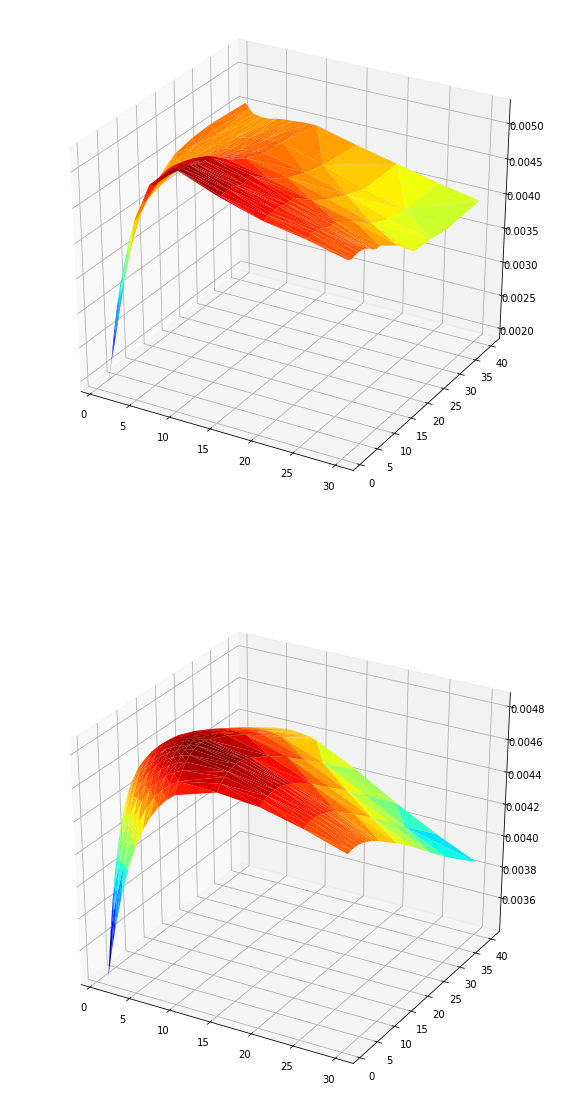

In [144]:
orig_volsurface  = vols.stack().reset_index().rename(columns = {0:'sigma'}).query('expiry>=1 and tenor >= 1')
model_volsurface = res.stack().reset_index().rename(columns = {0:'sigma'}).query('expiry>=1 and tenor >=1')

fig = plt.figure(figsize = (10, 20))
ax  = fig.add_subplot(211, projection='3d')
ax.plot_trisurf(orig_volsurface['expiry'],  orig_volsurface['tenor'], orig_volsurface['sigma'], cmap=cm.jet, linewidth=0.2)
ax  = fig.add_subplot(212, projection='3d')
ax.plot_trisurf(model_volsurface['expiry'], model_volsurface['tenor'], model_volsurface['sigma'], cmap=cm.jet, linewidth=0.2)

In [131]:
vols.columns = vols.columns.astype(float)